Demonstration of slowly varying neural participation profile during ensemble reactivation due to slow, random drifting excitabilities.

# Params

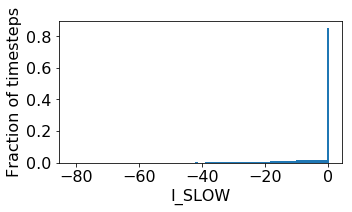

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d as smooth
import sys

from aux import r_tile, c_tile, Generic
from disp import set_font_size, set_color, fast_fig
from ntwk import BinarySTDPNtwk

cc = np.concatenate


# PARAMS
SEED = 1
np.random.seed(SEED)

## DYNAMICS/ADAPTATION
N_MAX = 150
THT_S = 1
T_THT = 4
A_THT = 1.5

## STRUCTURE
N = 1000
M = 200
Q = .1
W_MIN = THT_S/50 + .0001
W_MAX = THT_S/4 + .0001

## DRIVE
N_T = 1000
ITVL_REACT = 25  # TIME BTWN REACTIVATION EVENTS
T_REACT = np.arange(ITVL_REACT, N_T, ITVL_REACT)
I_STD_0 = .15  # BASELINE NOISE
I_STD_1 = .85  # REACTIVATION NOISE

I_REACT = I_STD_1 * np.random.randn(N)

I_MEAN_SLOW = 10
I_STD_SLOW = 15
TAU_I_SLOW = 100

I_SLOW = smooth(np.random.randn(N_T, N), TAU_I_SLOW, axis=0)
I_SLOW *= (I_STD_SLOW / I_SLOW.std(axis=0))
I_SLOW += I_MEAN_SLOW
I_SLOW[I_SLOW >= .5] = .5

# I_SLOW[:] = 0

fig, ax = plt.subplots(1, 1, figsize=(5, 3), tight_layout=True)
ax.hist(I_SLOW.flatten(), bins=100, normed=True)
ax.set_xlabel('I_SLOW')
ax.set_ylabel('Fraction of timesteps')
set_font_size(ax, 16)

# Smln

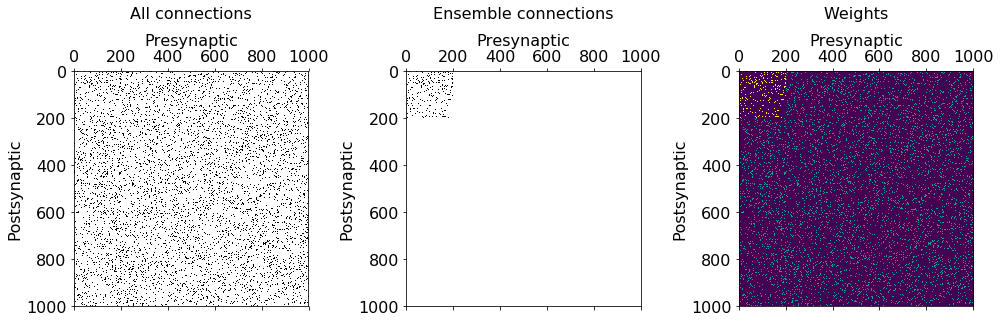

In [2]:
np.random.seed(SEED)

# set up weights
cxn = np.random.rand(N, N) < Q
w_0 = np.zeros((N, N))
w_0[cxn] = W_MIN

# set up strongly connected ensemble
ens_mask = np.zeros(N, dtype=bool)
ens_mask[:M] = True
ens_cxn = cxn & np.outer(ens_mask, ens_mask)
w_0[ens_cxn] = W_MAX

# plot cxn matrices and weight matrices
fig, axs = plt.subplots(1, 3, figsize=(14, 5), tight_layout=True)
axs[0].spy(cxn)
axs[0].set_title('All connections\n\n')
axs[1].spy(ens_cxn)
axs[1].set_title('Ensemble connections\n\n')
axs[2].matshow(w_0, vmin=0, vmax=.15*W_MAX)
axs[2].set_title('Weights\n\n')

for ax in axs:
    ax.set_xlabel('Presynaptic')
    ax.set_ylabel('Postsynaptic')
    ax.xaxis.set_label_position('top')
    set_font_size(ax, 16)

# set up inputs
i_ext = I_STD_0 * np.random.randn(N_T, N)
i_ext[T_REACT, :] = I_REACT

# add in slow-varying baseline inputs
i_ext += I_SLOW

# build ntwk and run smln
ntwk = BinarySTDPNtwk(
    cxn=cxn,
    w_0=w_0,
    tht_s=THT_S,
    t_tht=T_THT,
    a_tht=A_THT,
    n_max=N_MAX,
    t_stdp=np.arange(-10, 10),
    d_w_s=np.zeros(20),
    w_min=W_MIN,
    w_max=W_MAX)

rslt = ntwk.run(i_ext=i_ext, change_w=None)

# Analysis

In [3]:
# participation profiles during reactivation events
PCPN_CTR = [0, 1, 2, 10, 11, 12, -3, -2, -1]  # which reactivation events to measure participation profiles for
T_PCPN = 4  # how many timesteps post reactivation stim to count spks

pcpn_prfls = []
orders = []

for ctr in PCPN_CTR:
    # calc cell participations during reactivation
    pcpn_prfl = rslt.spks[T_REACT[ctr]+1:T_REACT[ctr]+T_PCPN+1, :].sum(0)
    pcpn_prfls.append(pcpn_prfl)
    
    # sort cells by participation
    order = pcpn_prfl.argsort()[::-1]
    pcpn_prfl_sorted = pcpn_prfl[order]
    
    # randomly permute sorted idxs of cells that had same num spikes during reactivation
    # (to avoid sorting algorithm artifacts when multiple cells have same participation)
    for n_spks in range(pcpn_prfl_sorted.max() + 1):
        tmp = order[pcpn_prfl_sorted == n_spks].copy()
        np.random.shuffle(tmp)
        order[pcpn_prfl_sorted == n_spks] = tmp
    
    orders.append(order)
    
# full participation profile covariance across reactivation events
pcpn_prfls_full = []
for ctr in range(len(T_REACT)):
    pcpn_prfl = rslt.spks[T_REACT[ctr]+1:T_REACT[ctr]+T_PCPN+1, :].sum(0)
    pcpn_prfls_full.append(pcpn_prfl)

pcpn_prfls_full = np.array(pcpn_prfls_full)

# Results

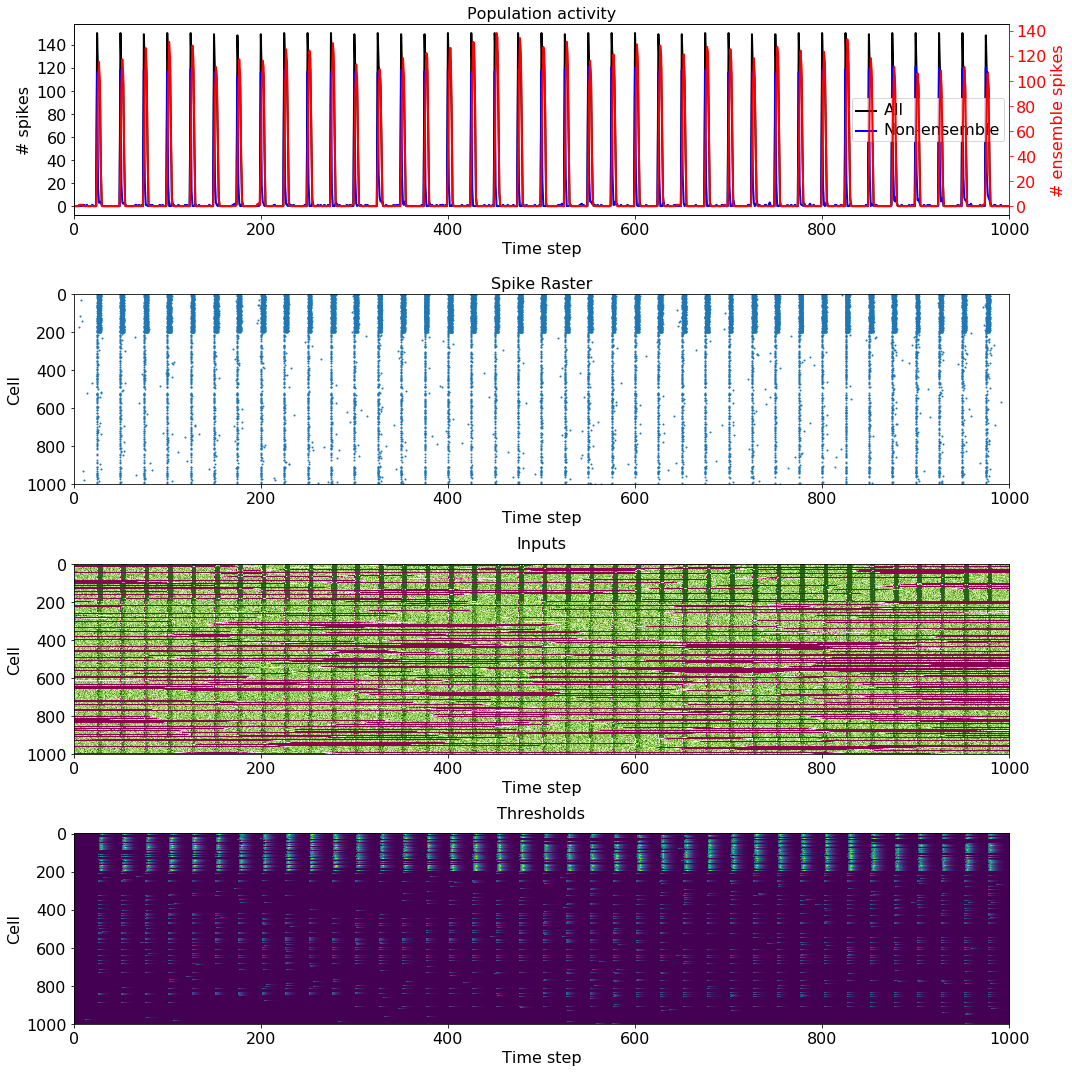

In [4]:
# plot dynamics
fig, axs = plt.subplots(4, 1, figsize=(15, 15), tight_layout=True)

## population activity
axs[0].plot(rslt.t, rslt.spks.sum(1), lw=2, color='k')
axs[0].plot(rslt.t, rslt.spks[:, ~ens_mask].sum(1), lw=2, color='b')
axs[0].set_xlim(0, N_T)
axs[0].set_xlabel('Time step')
axs[0].set_ylabel('# spikes')
axs[0].legend(['All', 'Non-ensemble'])
axs[0].set_title('Population activity')

ax_twin = axs[0].twinx()
ax_twin.plot(rslt.t, rslt.spks[:, ens_mask].sum(1), lw=2, color='r')
ax_twin.set_xlim(0, N_T)
ax_twin.set_ylabel('# ensemble spikes')

set_color(ax_twin, 'r')

## raster
axs[1].scatter(*np.nonzero(rslt.spks), s=1)
axs[1].set_xlim(0, N_T)
axs[1].set_ylim(N, -1)
axs[1].set_xlabel('Time step')
axs[1].set_ylabel('Cell')
axs[1].set_title('Spike Raster')

## inputs
axs[2].matshow(rslt.vs.T, origin='upper', aspect='auto', cmap='PiYG', vmin=-1, vmax=1)
axs[2].xaxis.tick_bottom()
axs[2].set_xlim(0, N_T)
axs[2].set_xlabel('Time step')
axs[2].set_ylabel('Cell')
axs[2].set_title('Inputs')

## thresholds
axs[3].matshow(rslt.thts.T, origin='upper', aspect='auto')
axs[3].xaxis.tick_bottom()
axs[3].set_xlim(0, N_T)
axs[3].set_xlabel('Time step')
axs[3].set_ylabel('Cell')
axs[3].set_title('Thresholds')

for ax in list(axs) + [ax_twin]:
    set_font_size(ax, 16)

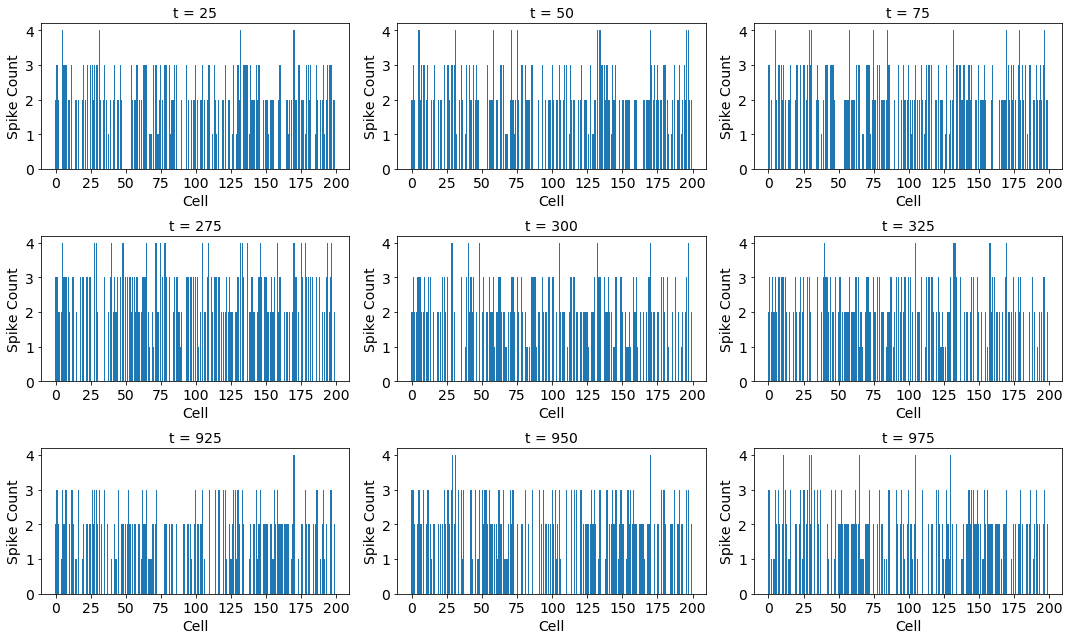

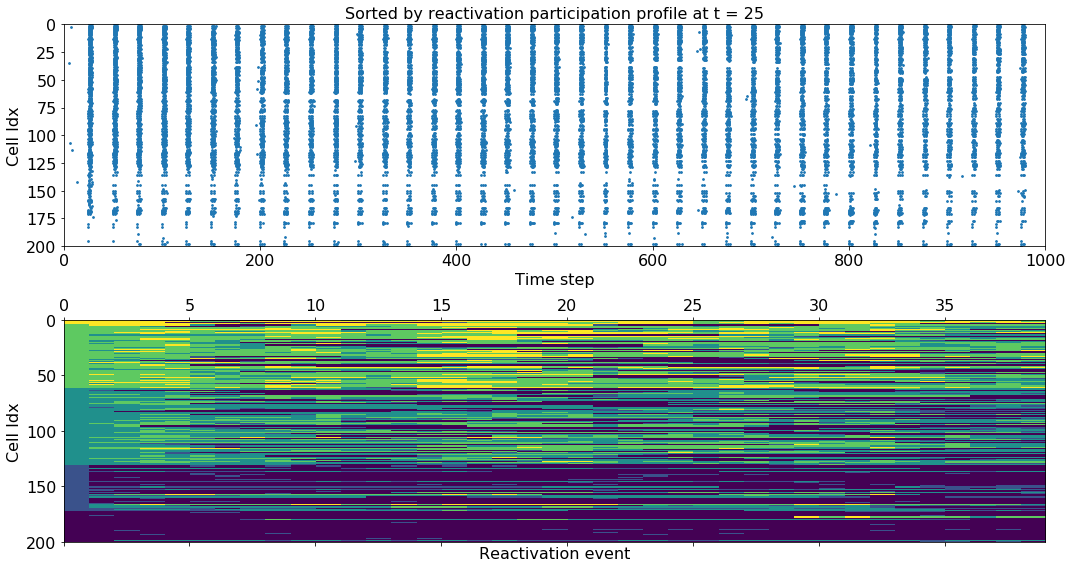

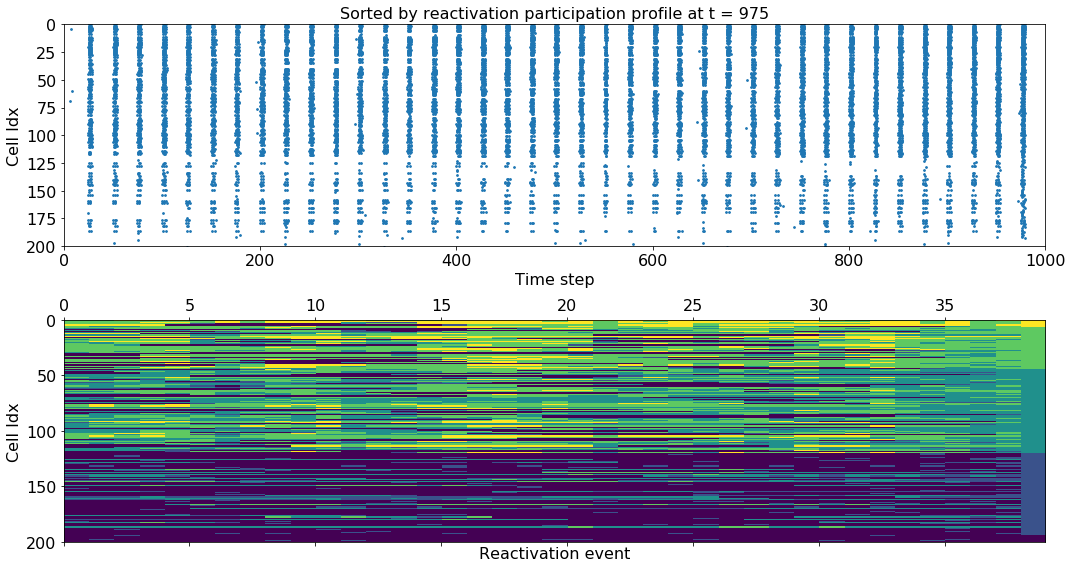

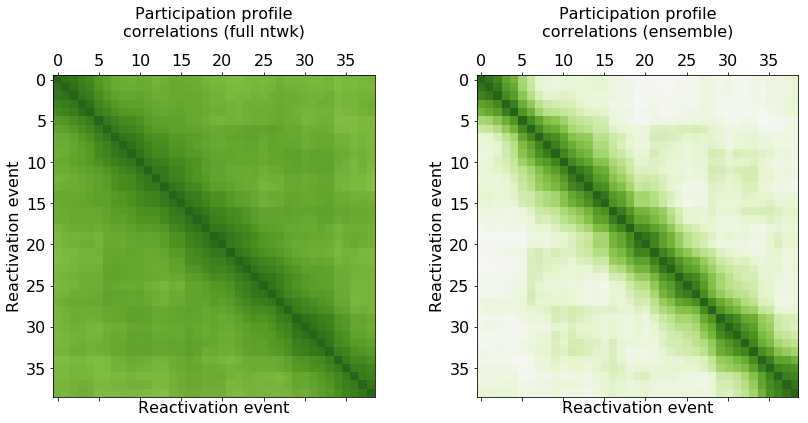

In [5]:
# plot participation profiles
fig, axs = fast_fig(len(PCPN_CTR), ax_size=(3, 5), fig_w=15)
for ax, pcpn_ctr, pcpn_prfl in zip(axs, PCPN_CTR, pcpn_prfls):
    ax.bar(np.arange(M), pcpn_prfl[:M], align='center')
    ax.set_xlabel('Cell')
    ax.set_ylabel('Spike Count')
    ax.set_title('t = {}'.format(T_REACT[pcpn_ctr]))
    set_font_size(ax, 14)
    
# plot rasters sorted by initial and final participations
for ctr in [0, -1]:
    
    fig, axs = plt.subplots(2, 1, figsize=(15, 8), tight_layout=True)
    spk_t, spk_idx_ = np.nonzero(rslt.spks)
    # reindex spikes to be sorted by participation
    spk_idx = np.argsort(orders[ctr])[spk_idx_]
    
    # plot raster
    axs[0].scatter(spk_t, spk_idx, s=3)
    axs[0].set_xlim(0, N_T)
    axs[0].set_ylim(M, 0)
    axs[0].set_xlabel('Time step')
    axs[0].set_ylabel('Cell Idx')
    axs[0].set_title('Sorted by reactivation participation profile at t = {}'.format(T_REACT[PCPN_CTR[ctr]]))
    
    # plot participation profile evolution
    axs[1].matshow(pcpn_prfls_full[:, orders[ctr]].T, extent=[0, len(T_REACT), N, 0])
    axs[1].set_aspect('auto')
    axs[1].set_ylim(M, 0)
    axs[1].set_xlabel('Reactivation event')
    axs[1].set_ylabel('Cell Idx')
    
    for ax in axs:
        set_font_size(ax, 16)
    
# plot participation profile correlation across reactivation events
fig, axs = plt.subplots(1, 2, figsize=(12, 6), tight_layout=True)
axs[0].matshow(np.corrcoef(pcpn_prfls_full), interpolation='nearest', cmap='PiYG', vmin=-1, vmax=1)
axs[0].set_title('Participation profile\ncorrelations (full ntwk)\n')

axs[1].matshow(np.corrcoef(pcpn_prfls_full[:, :M]), interpolation='nearest', cmap='PiYG', vmin=-1, vmax=1)
axs[1].set_title('Participation profile\ncorrelations (ensemble)\n')

for ax in axs:
    ax.set_xlabel('Reactivation event')
    ax.set_ylabel('Reactivation event')
    set_font_size(ax, 16)